In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import math
import numpy as np
import copy
import time
import pickle
from random import seed, shuffle, sample

from sklearn.preprocessing import StandardScaler
from aif360.datasets import AdultDataset, CompasDataset, GermanDataset, BankDataset, StandardDataset

import matplotlib
import matplotlib.pyplot as plt
import os

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

%matplotlib inline

In [2]:
sys.path.append('../baselines/iFair/')
sys.path.append('../baselines/LFR/')
sys.path.append('../baselines/PFR/')
sys.path.append('../iFlipper/')

from iflipper import iFlipper
from aif360.algorithms.preprocessing import LFR
from iFair import iFair
from PFR import PFR, similarity_pfr, estimate_dim

from cplex_solver import CPLEX_Solver
from greedy import Greedy
from gradient import Gradient
from kmeans import kMeans

from utils import measure_error, generate_sim_matrix
from model import Model

# Load fairness dataset from AIF360 and define variables
### 1. Dataset = COMPAS, AdultCensus, Credit
### 2. Similarity matrix = knn, threshold
### 3. ML model = LogisticRegression, RandomForest, NeuralNetwork

In [3]:
dataset_type = "COMPAS" # AdultCensus, Credit
similarity_matrix = "knn" # threshold
model_type = "LogisticRegression" # RandomForest, NeuralNetwork

PRINT_RESULT = False

In [4]:
similarity_params = dict()

if dataset_type == "COMPAS":
    dataset = CompasDataset(label_name='two_year_recid', favorable_classes=[0], 
                            protected_attribute_names=['sex'], privileged_classes=[['Female']], 
                            categorical_features=['age_cat', 'c_charge_degree', 'c_charge_desc', 'race'], 
                            features_to_keep=['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'c_charge_desc', 'two_year_recid'], 
                            features_to_drop=[], na_values=[])
    protected = "sex"
    num_train, num_test, num_val = 0.6, 0.3, 0.1
    
    similarity_params["num_hash"], similarity_params["num_table"], similarity_params["theta"] = 1, 10, 0.05
    similarity_params["k"], similarity_params["threshold"] = 20, 3

    m_list = [15000, 1500, 150]
    
elif dataset_type == "AdultCensus":
    dataset = AdultDataset(label_name='income-per-year', favorable_classes=['>50K', '>50K.'], 
                    protected_attribute_names=['sex'], privileged_classes=[['Male']], 
                    categorical_features=['race', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'native-country'], 
                    features_to_keep=[], features_to_drop=['fnlwgt'], na_values=['?'])
    protected = "sex"
    num_train, num_test, num_val = 0.6, 0.3, 0.1

    similarity_params["num_hash"], similarity_params["num_table"], similarity_params["theta"] = 10, 50, 0.1
    similarity_params["k"], similarity_params["threshold"]  = 20, 3

    m_list = [10000, 1000, 100]
    
elif dataset_type == "Credit":
    def label_processing(df):
        credit_map = {1.0 : 1.0, 2.0 : 0.0}
        status_map = {'A91': 'male', 'A93': 'male', 'A94': 'male',
                      'A92': 'female', 'A95': 'female'}
        df['credit'] = df['credit'].replace(credit_map)
        df['sex'] = df['personal_status'].replace(status_map)    
        return df
    
    dataset = GermanDataset(custom_preprocessing = label_processing, 
                            metadata={'label_maps': [{1.0: 'Good Credit', 0.0: 'Bad Credit'}], 'protected_attribute_maps': [{1.0: 'Male', 0.0: 'Female'}, {1.0: 'Old', 0.0: 'Young'}]})
    protected = "age"
    num_train, num_test, num_val = 0.7, 0.2, 0.1

    similarity_params["num_hash"], similarity_params["num_table"], similarity_params["theta"] = 1, 10, 0.05
    similarity_params["k"], similarity_params["threshold"]  = 20, 7
    
    m_list = [1000, 100, 0]

privileged_groups = [{protected: 1}]
unprivileged_groups = [{protected: 0}]

In [5]:
scaler = StandardScaler()
train, test, val = dataset.split([num_train, num_train+num_test], shuffle=True, seed=0)

train.features = scaler.fit_transform(train.features)
test.features = scaler.fit_transform(test.features)
val.features = scaler.fit_transform(val.features)
index = train.feature_names.index(protected)

# remove sensitive features
x_train = np.delete(train.features, index, axis=1)
x_test = np.delete(test.features, index, axis=1)
x_val = np.delete(val.features, index, axis=1)

y_train = train.labels.ravel()
y_test = test.labels.ravel()
y_val = val.labels.ravel()

# keep sensitive column for PFR
train_sensitive = np.reshape(train.features[:, index], (-1, 1))
test_sensitive = np.reshape(test.features[:, index], (-1, 1))
val_sensitive = np.reshape(val.features[:, index], (-1, 1))

# For iFair
x_train_with_sensitive = np.concatenate((x_train, train_sensitive), axis = 1)
x_test_with_sensitive = np.concatenate((x_test, test_sensitive), axis = 1)
x_val_with_sensitive = np.concatenate((x_val, val_sensitive), axis = 1)

print("Dataset: %s" % dataset_type)
print("Number of training data: %d, Number of test data: %d, Number of validation data: %d\n" % (x_train.shape[0], x_test.shape[0], x_val.shape[0]))

Dataset: COMPAS
Number of training data: 3700, Number of test data: 1850, Number of validation data: 617



# Obtain similarity matrix

In [6]:
w_train, edge_train, w_edge_train = generate_sim_matrix(x_train, similarity_matrix, similarity_params)
w_test, edge_test, w_edge_test = generate_sim_matrix(x_test, similarity_matrix, similarity_params)
w_val, edge_val, w_edge_val = generate_sim_matrix(x_val, similarity_matrix, similarity_params)

# Initial amount of total error

In [7]:
total_error_arr, num_flips_arr, runtime = dict(), dict(), dict()

init_error = measure_error(y_train, edge_train, w_edge_train)
print(f"Initial number of violations: {init_error:.1f}")

Initial number of violations: 16454.0


# iFlipper on different total error limits (m)

In [8]:
method = "iFlipper"
total_error_arr[method], num_flips_arr[method], runtime[method] = [], [], []

for m in m_list:
    start = time.time()
    IFLIP = iFlipper(y_train, w_train, edge_train, w_edge_train)
    flipped_label = IFLIP.transform(m)
    elapsed_time = time.time() - start

    total_error = measure_error(flipped_label, edge_train, w_edge_train)
    num_flips = np.sum(y_train != flipped_label)

    total_error_arr[method].append(total_error)
    num_flips_arr[method].append(num_flips)
    runtime[method].append(elapsed_time)

    if PRINT_RESULT:
        print("============================")
        print(f"Total error limit: {m:.1f}")
        print(f"Total error: {total_error:.1f}")
        print(f"Number of flips: {num_flips}")
        print(f"Runtime (sec): {elapsed_time:.5f}")

# Greedy algorithm
## Flips labels that reduce the total error the most.

In [9]:
method = "Greedy"
total_error_arr[method], num_flips_arr[method], runtime[method] = [], [], []

for m in m_list:
    start = time.time()
    flipped_label = Greedy(y_train, m, w_train, edge_train, w_edge_train)
    elapsed_time = time.time() - start

    total_error = measure_error(flipped_label, edge_train, w_edge_train)
    num_flips = np.sum(y_train != flipped_label)

    total_error_arr[method].append(total_error)
    num_flips_arr[method].append(num_flips)
    runtime[method].append(elapsed_time)

    if PRINT_RESULT:
        print("============================")
        print(f"Total error limit: {m:.1f}")
        print(f"Total error: {total_error:.1f}")
        print(f"Number of flips: {num_flips}")
        print(f"Runtime (sec): {elapsed_time:.5f}")

no more reduction


# Gradient-based algorithm
## Solves an unconstrained optimization problem via gradient descent

In [10]:
method = "Gradient"
total_error_arr[method], num_flips_arr[method], runtime[method] = [], [], []

for m in m_list:
    start = time.time()
    flipped_label = Gradient(y_train, m, edge_train, w_edge_train, lam_high=60)
    elapsed_time = time.time() - start

    total_error = measure_error(flipped_label, edge_train, w_edge_train)
    num_flips = np.sum(y_train != flipped_label)

    total_error_arr[method].append(total_error)
    num_flips_arr[method].append(num_flips)
    runtime[method].append(elapsed_time)

    if PRINT_RESULT:
        print("============================")
        print(f"Total error limit: {m:.1f}")
        print(f"Total error: {total_error:.1f}")
        print(f"Number of flips: {num_flips}")
        print(f"Runtime (sec): {elapsed_time:.5f}")

# kMeans-based algorithm
## Applies k-means clustering and, for each cluster, make its examples have the majority label.

In [11]:
method = "kMeans"
total_error_arr[method], num_flips_arr[method], runtime[method] = [], [], []

for m in m_list:
    start = time.time()
    flipped_label = kMeans(x_train, y_train, m, edge_train, w_edge_train)
    elapsed_time = time.time() - start
    
    total_error = measure_error(flipped_label, edge_train, w_edge_train)
    num_flips = np.sum(y_train != flipped_label)

    total_error_arr[method].append(total_error)
    num_flips_arr[method].append(num_flips)
    runtime[method].append(elapsed_time)

    if PRINT_RESULT:
        print("============================")
        print(f"Total error limit: {m:.1f}")
        print(f"Total error: {total_error:.1f}")
        print(f"Number of flips: {num_flips}")
        print(f"Runtime (sec): {elapsed_time:.5f}")

# ILP Solver
## Solves the ILP problem exactly using CPLEX, which is a state-of-the-art solver.

In [12]:
method = "ILP"
total_error_arr[method], num_flips_arr[method], runtime[method] = [], [], []

for m in m_list:
    start = time.time()
    flipped_label = CPLEX_Solver(y_train, m, w_train, edge_train, ILP = True)
    elapsed_time = time.time() - start

    total_error = measure_error(flipped_label, edge_train, w_edge_train)
    num_flips = np.sum(y_train != flipped_label)

    total_error_arr[method].append(total_error)
    num_flips_arr[method].append(num_flips)
    runtime[method].append(elapsed_time)

    if PRINT_RESULT:
        print("============================")
        print(f"Total error limit: {m:.1f}")
        print(f"Total error: {total_error:.1f}")
        print(f"Number of flips: {num_flips}")
        print(f"Runtime (sec): {elapsed_time:.5f}")

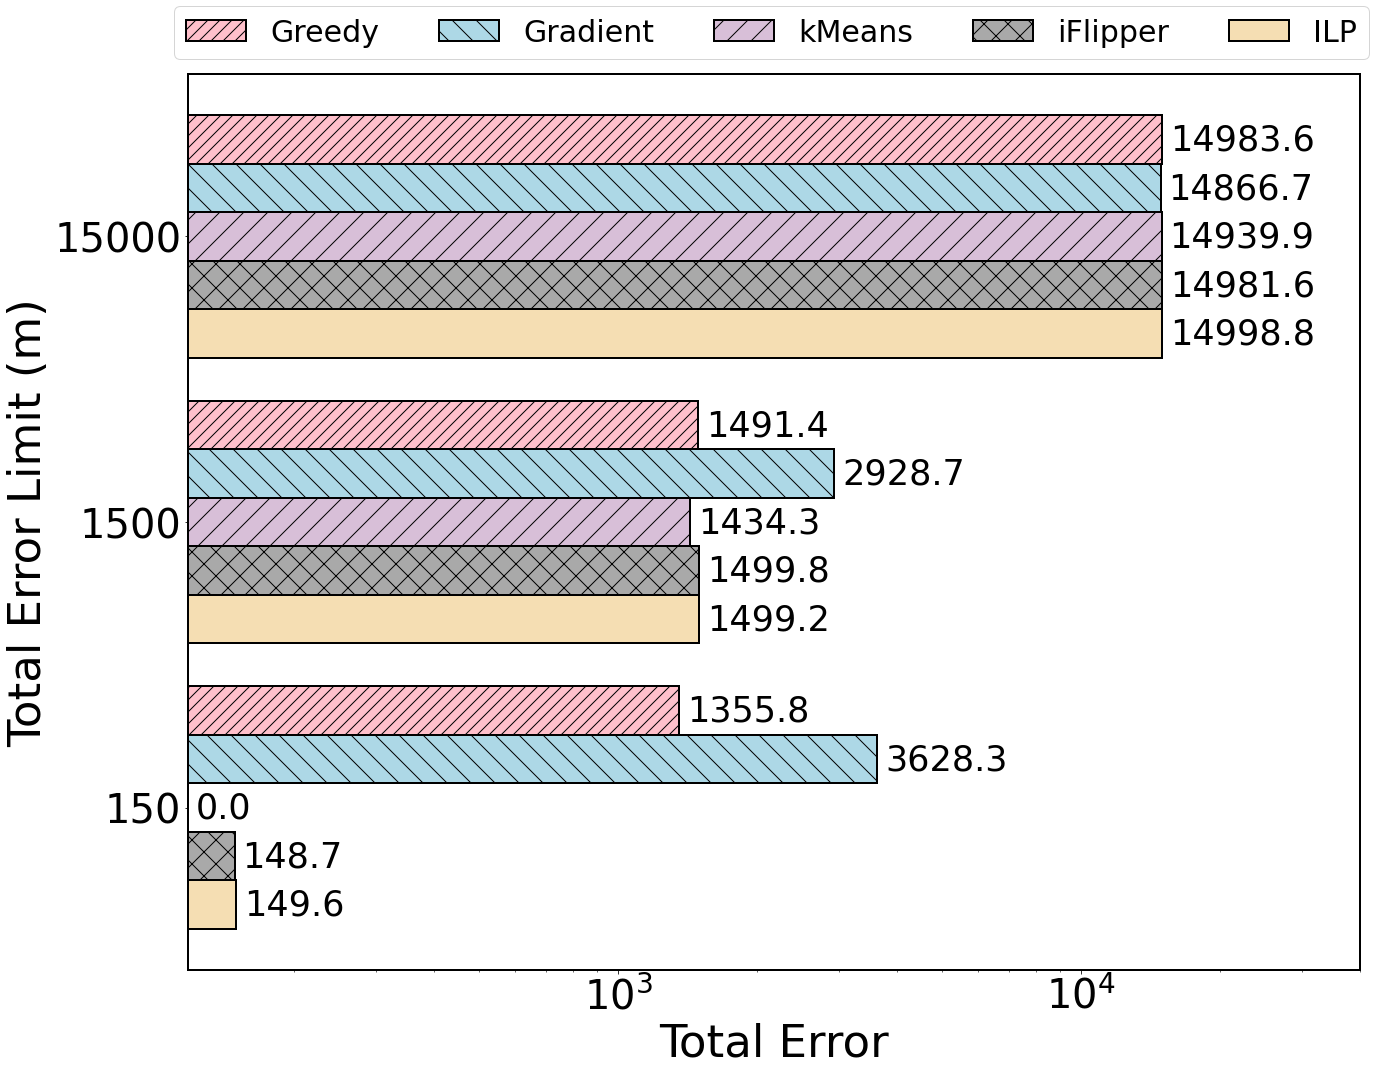

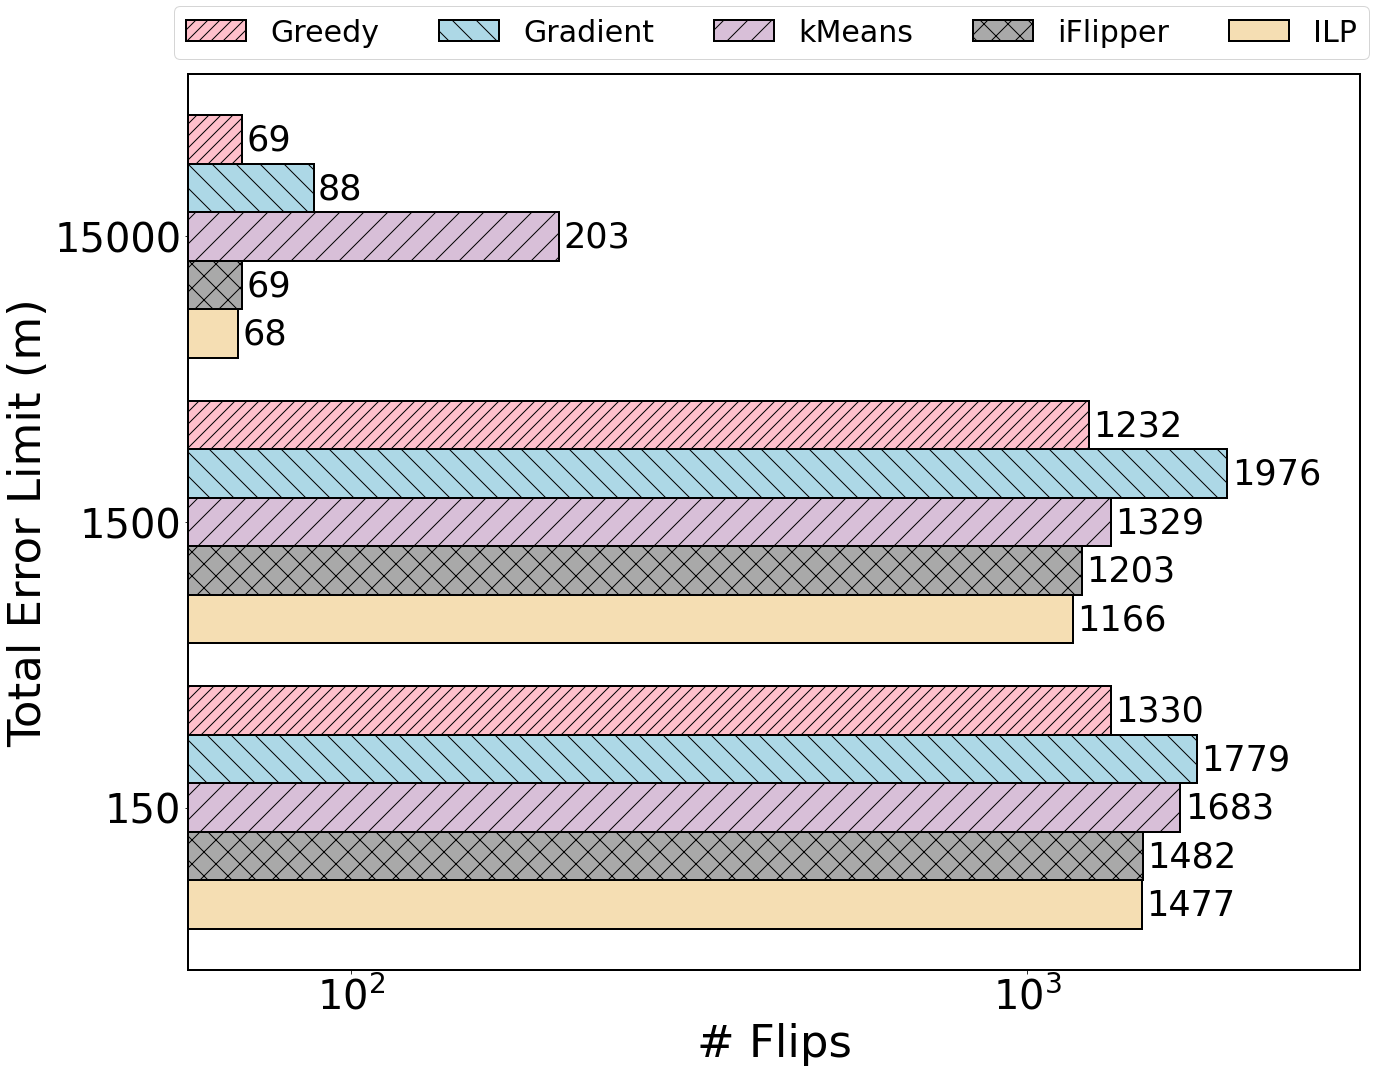

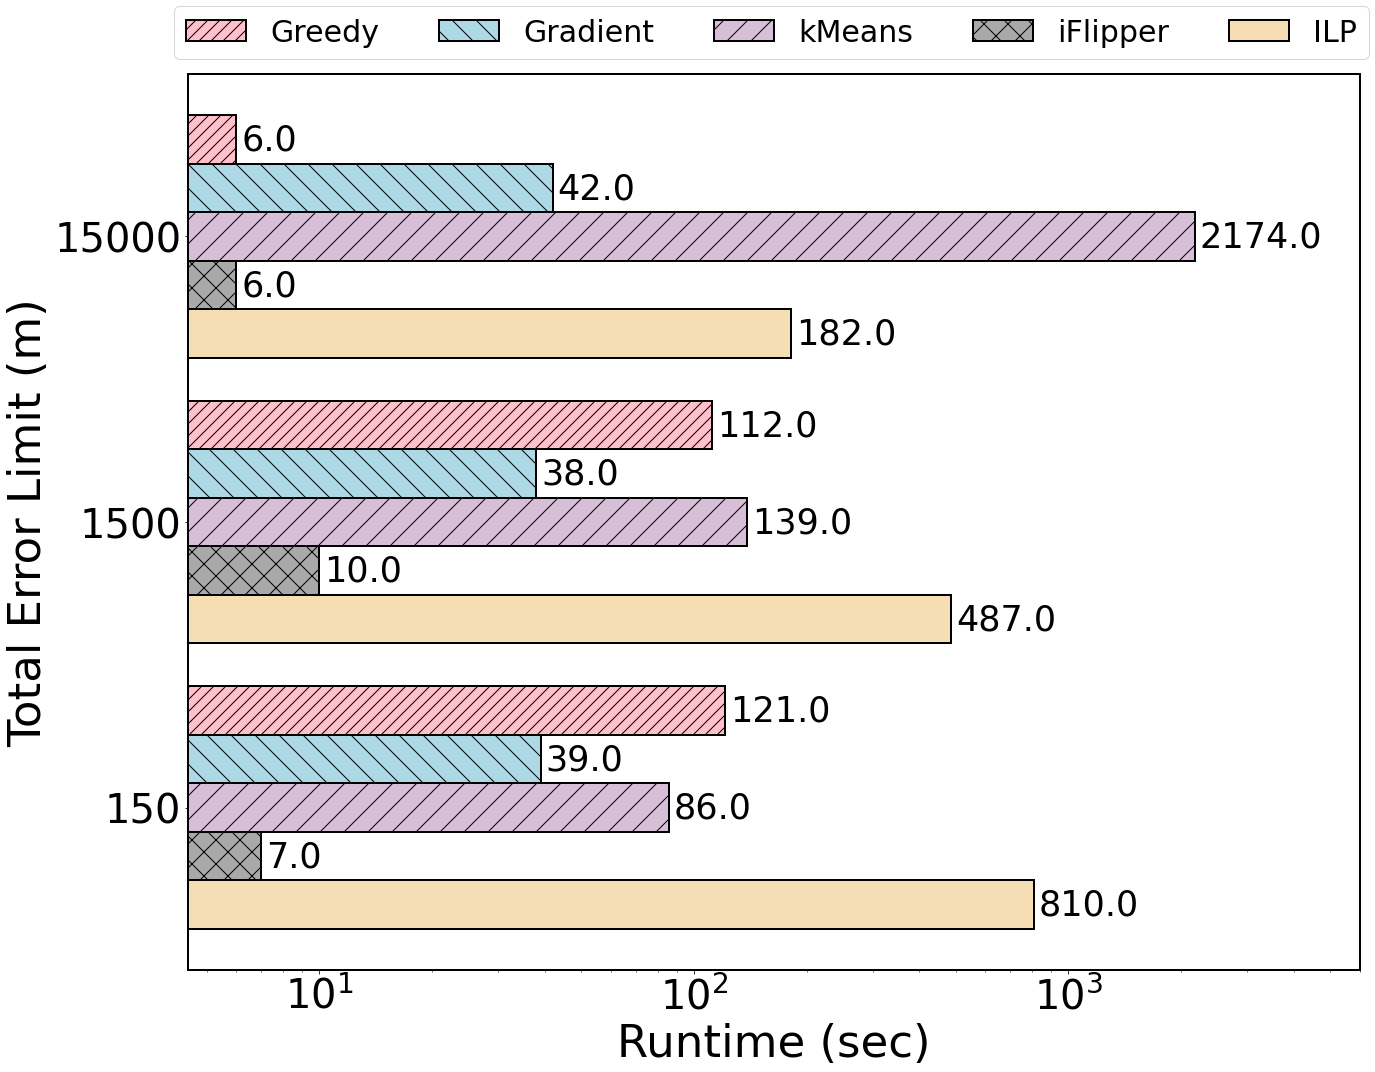

In [13]:
def plot_result(m_list, performance_arr, y_axis, num_digits):
    labels = np.array(m_list)[::-1]

    plot1 = np.array(performance_arr["Greedy"])[::-1]
    plot2 = np.array(performance_arr["Gradient"])[::-1]
    plot3 = np.array(performance_arr["kMeans"])[::-1]
    plot4 = np.array(performance_arr["iFlipper"])[::-1]
    plot5 = np.array(performance_arr["ILP"])[::-1]

    x = np.arange(len(labels)) # the label locations
    width = 0.17  # the width of the bars

    plt.figure(1, figsize=(20,15))
    ax = plt.subplot()
    [x.set_linewidth(2) for x in ax.spines.values()]

    rects1 = ax.barh(x + width * 2, np.round(plot1, num_digits), width, label="Greedy", color="pink", hatch='//',edgecolor="black", linewidth=2)
    rects2 = ax.barh(x + width * 1, np.round(plot2, num_digits), width, label="Gradient", color="lightblue", hatch='\\',edgecolor="black", linewidth=2)
    rects3 = ax.barh(x - width * 0, np.round(plot3, num_digits), width, label="kMeans", color="thistle", hatch='/',edgecolor="black", linewidth=2)
    rects4 = ax.barh(x - width * 1, np.round(plot4, num_digits), width, label="iFlipper", color="darkgray", hatch='X',edgecolor="black", linewidth=2)
    rects5 = ax.barh(x - width * 2, np.round(plot5, num_digits), width, label="ILP", color="wheat", edgecolor="black", linewidth=2)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    plt.tick_params(labelsize=40)
    ax.set_xlabel(y_axis, fontsize=45)
    ax.set_ylabel("Total Error Limit (m)", fontsize=45)

    ax.set_yticks(x)
    ax.set_yticklabels(labels)
    ax.set_xscale('log')
    plt.legend(prop={'size':30}, bbox_to_anchor=(-0.025, 1), loc="lower left", ncol=5)
    
    max_val, max_ratio = 0, 1
    if y_axis =="Total Error":
        max_val = 118
        plt.xlim(0, 40000)
        max_ratio = 1.04
    elif y_axis =="# Flips":
        plt.minorticks_off()
        plt.xlim(0, 3100)
        max_ratio = 1.015
    else:
        plt.xlim(0, 6000)
        max_ratio =1.03
        
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            ax.annotate('{}'.format(rect.get_width()),
                        xy=(max(rect.get_width(), max_val)*max_ratio, rect.get_y() + rect.get_height()*0.285),
                        fontsize=35)
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)
    autolabel(rects5)

    plt.tight_layout()
    plt.show()

plot_result(m_list, total_error_arr, "Total Error", 1)
plot_result(m_list, num_flips_arr, "# Flips", 0)
plot_result(m_list, runtime, "Runtime (sec)", 0)